In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, roc_auc_score,accuracy_score,auc

from wordcloud import WordCloud


In [112]:
model_path = 'data/model_annotations_liwc_h.xlsx'
dfm = pd.read_excel(model_path, engine='openpyxl')
dfm.drop("Segment", axis=1, inplace=True)
dfm.head()

,text,proc_text,model_unanimous,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,"Dear World:family_man_woman_girl_boy:, you nee...","Dear World:family_man_woman_girl_boy:, you nee...",PO,32,52.84,75.49,1.63,1.00,16.0,46.88,...,0.0,0.0,59.38,3.13,6.25,0.0,0.0,0.00,50.00,12.5
1,.@fordnation says releasing the projection mod...,.@fordnation says releasing the projection mod...,PO,28,96.35,3.12,48.09,1.00,28.0,35.71,...,0.0,0.0,32.14,3.57,3.57,0.0,0.0,3.57,21.43,0.0
2,"""Neurologists around the world say that a smal...","""Neurologists around the world say that a smal...",UN,34,93.03,24.36,4.60,20.23,17.0,29.41,...,0.0,0.0,20.59,2.94,0.00,0.0,0.0,2.94,14.71,0.0
3,Coronavirus: More than one million cases confi...,Coronavirus: More than one million cases confi...,UN,34,93.03,40.06,12.44,1.85,17.0,41.18,...,0.0,0.0,14.71,5.88,0.00,0.0,0.0,0.00,8.82,0.0
4,"This is my Gov, @henrymcmaster, today, 4/2/202...","This is my Gov, @henrymcmaster, today, 4/2/202...",UN,42,81.45,54.27,72.58,3.20,10.5,30.95,...,0.0,0.0,38.10,7.14,11.90,0.0,0.0,2.38,16.67,0.0


In [149]:
human_path = 'data/r1_r2_annotations_liwc_h.xlsx'
benchmark = pd.read_excel(human_path, engine='openpyxl')
benchmark = benchmark[benchmark['majority_vote'] != "NoMajority"]
benchmark.reset_index(drop=True, inplace=True)

benchmark_tweet = benchmark.copy(deep=True)['proc_text']
benchmark_full = benchmark.copy(deep=True)
benchmark_full = benchmark_full.drop(
    ['text', 'proc_text', 'A1', 'A2', 'A3', 'A4', "A5", 'A6', 'majority_vote', "roundID", "Segment"], axis=1)
benchmark_target = benchmark.copy(deep=True)['majority_vote']


In [144]:
display(benchmark_full.head(2))
display(benchmark_tweet.head(2))
display(benchmark_target.head(2))

majority_vote
NoMajority    168
PO            160
UN             98
PP             95
Name: count, dtype: int64


,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,function,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,26,4.85,7.93,81.58,1.0,8.67,26.92,92.31,61.54,46.15,...,0.0,0.0,26.92,7.69,3.85,0.0,0.0,3.85,11.54,0.0
1,25,1.00,1.00,85.71,1.0,12.50,16.00,96.00,72.00,68.00,...,0.0,0.0,28.00,12.00,0.00,0.0,0.0,8.00,8.00,16.0


0    Fuck you china. I was 2 years clear of severe ...
1    Feeling so off today and I can’t tell if this ...
Name: proc_text, dtype: object

0    PP
1    PP
Name: majority_vote, dtype: object

In [150]:
print(dfm.columns.values)

['text' 'proc_text' 'WC' 'Analytic' 'Clout' 'Authentic' 'Tone' 'WPS'
 'BigWords' 'Dic' 'Linguistic' 'function' 'pronoun' 'ppron' 'i' 'we' 'you'
 'shehe' 'they' 'ipron' 'det' 'article' 'number' 'prep' 'auxverb' 'adverb'
 'conj' 'negate' 'verb' 'adj' 'quantity' 'Drives' 'affiliation' 'achieve'
 'power' 'Cognition' 'allnone' 'cogproc' 'insight' 'cause' 'discrep'
 'tentat' 'certitude' 'differ' 'memory' 'Affect' 'tone_pos' 'tone_neg'
 'emotion' 'emo_pos' 'emo_neg' 'emo_anx' 'emo_anger' 'emo_sad' 'swear'
 'Social' 'socbehav' 'prosocial' 'polite' 'conflict' 'moral' 'comm'
 'socrefs' 'family' 'friend' 'female' 'male' 'Culture' 'politic'
 'ethnicity' 'tech' 'Lifestyle' 'leisure' 'home' 'work' 'money' 'relig'
 'Physical' 'health' 'illness' 'wellness' 'mental' 'substances' 'sexual'
 'food' 'death' 'need' 'want' 'acquire' 'lack' 'fulfill' 'fatigue'
 'reward' 'risk' 'curiosity' 'allure' 'Perception' 'attention' 'motion'
 'space' 'visual' 'auditory' 'feeling' 'time' 'focuspast' 'focuspresent'
 'focu

In [151]:
target = dfm['model_unanimous']
dfm.drop(['model_unanimous'], inplace=True, axis=1)

KeyError: 'model_unanimous'

## tfid vectorizing


In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    dfm, target, test_size=0.2, random_state=42)

X_train_tweet = X_train["proc_text"]
X_test_tweet = X_test["proc_text"]
X_train.drop(['proc_text', "text"], inplace=True, axis=1)
X_test.drop(['proc_text', "text"], inplace=True, axis=1)

# Vectorizing the tweets
# vectorizer = CountVectorizer(stop_words='english')
tf_id_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tweet_tfid = tf_id_vectorizer.fit_transform(X_train_tweet)
X_test_tweet_tfid = tf_id_vectorizer.transform(X_test_tweet)

In [118]:
# Generating TF-IDF vectors for visualization
texts = dfm['proc_text'].values
tfidf_matrix = X_train_tweet_tfid

# Converting TF-IDF matrix to dense format and getting feature names
tfidf_dense = tfidf_matrix.todense()
feature_names = tf_id_vectorizer.get_feature_names_out()

# Creating a DataFrame for easier manipulation
df_tfidf = pd.DataFrame(tfidf_dense, columns=feature_names)

In [119]:
# Summarizing the TF-IDF scores for each word across all documents to rank them
word_tfidf_sum = df_tfidf.sum().sort_values(ascending=False)

print(word_tfidf_sum.head(20))

coronavirus    372.279348
panic          367.206915
covid19        333.077420
don            171.895740
amp            164.862996
people         161.874644
covid_19       140.148427
hands          136.723301
shake          118.640937
pandemic       117.400552
stay           114.336493
covid          106.247582
chill          103.839694
shaking        100.910749
just            98.860785
buying          98.023724
need            89.124056
symptoms        88.639297
time            87.242647
home            84.627209
dtype: float64


In [12]:
# heatmap
# plt.figure(figsize=(12, 12))
# sns.heatmap(df_tfidf.iloc[:, :40], cmap='YlGnBu')
# plt.title('TF-IDF Scores Heatmap for Top 30 Words in All Documents')
# plt.xlabel('Top 30 Words')
# plt.ylabel('Documents')
# plt.show()

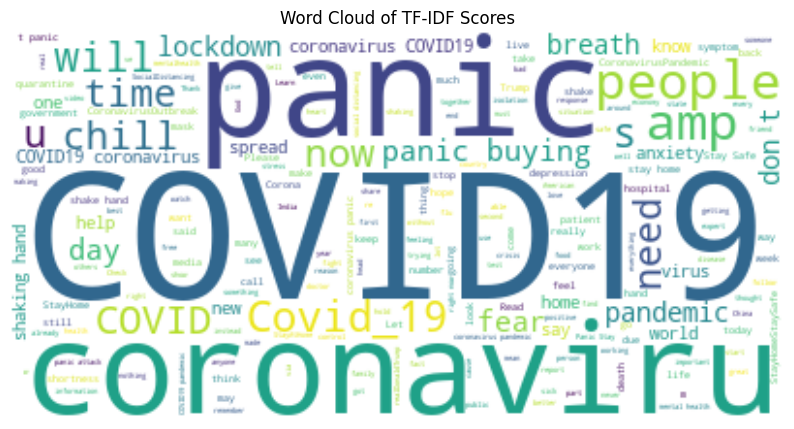

In [13]:
# word cloud
combined_texts = ' '.join(texts)
wordcloud = WordCloud(background_color='white',
                      max_words=200).generate(combined_texts)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Scores')
plt.show()

## bag of words


In [120]:
# Applying Bag of Words model on the processed text
count_vect = CountVectorizer(
    stop_words='english', min_df=0.01, max_features=5000)
X_train_bow = count_vect.fit_transform(X_train_tweet)
X_test_bow = count_vect.transform(X_test_tweet)

# Converting BoW matrix to DataFrame for easier visualization
feature_names_bow = count_vect.get_feature_names_out()
df_bow = pd.DataFrame(X_train_bow.toarray(), columns=feature_names_bow)
# Displaying the shape of the BoW matrix and the first few rows of the DataFrame
df_bow_shape = df_bow.shape
print('Shape of Bag of Words Matrix:', df_bow_shape)
display(df_bow.head())

Shape of Bag of Words Matrix: (10142, 220)


,000,10,19,2020,able,americans,amid,amp,anxiety,april,...,watch,way,week,weeks,won,work,workers,working,world,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## word2vec


In [121]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Tokenizing the processed text
train_texts_tokenized = [word_tokenize(text) for text in X_train_tweet]
test_texts_tokenized = [word_tokenize(text) for text in X_test_tweet]

# Training a Word2Vec model
word2vec_model = Word2Vec(sentences=train_texts_tokenized,
                          vector_size=100, window=5, min_count=1, workers=4)

# Summarizing the model
print('Word2Vec model trained.')
print('Vocabulary size:', len(word2vec_model.wv.key_to_index))

# Exploring word vectors
example_word = 'panic'
example_vector = word2vec_model.wv[example_word]
print(f'Vector representation for "{example_word}":\
{example_vector}')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaisb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Word2Vec model trained.
Vocabulary size: 36055
Vector representation for "panic":[-0.2941911   1.7441838   0.4707231   0.6184748   1.7010026  -1.8702385
  0.4526816   2.1137807  -0.19788708  0.35147735  0.15967777 -2.368362
  1.1487167  -0.3364593   1.4095083   0.14409135  0.24848148 -0.18041383
 -1.5866679  -1.9181966  -0.2874186   1.6349931   1.0721396  -1.4792532
  1.1776469  -0.55352527 -0.3756494  -1.3186728  -1.2971594   0.19199152
  2.2907636  -0.81085634  1.4483625  -0.7469631  -1.6467353   2.2577982
  0.8464413   0.34875423  0.48569334 -3.2940505  -1.0018059  -0.47654673
 -0.26260334  0.0664534  -0.25433615 -0.32379165 -0.94879395  1.3367887
 -0.40252203  1.4434423   0.7288139  -1.0286434   0.05584948 -0.34606844
  0.0899222   0.77727455  2.4238281   1.8387198  -0.17452317  0.25599375
  0.27792004  0.28946856  1.7847475   0.48378512 -0.47601944  0.75815773
 -0.6160257   0.81059396 -1.1341124   0.23548277 -1.1361763  -0.18882716
  1.763714    0.3535156   1.2746269  -1.2566729  

In [122]:
import numpy as np

# Function to convert texts into a mean vector using Word2Vec model


def tokenized_text_to_mean_vector(text_list, model):
    # Filter the words in text that are in the model's vocabulary
    vector_list = [model.wv[word]
                   for word in text_list if word in model.wv.key_to_index]
    if len(vector_list) > 0:
        mean_vector = np.mean(vector_list, axis=0)
    else:
        mean_vector = np.zeros(model.vector_size)
    return mean_vector


def text_to_mean_vector(text, model):
    tokenized_text = word_tokenize(text)
    return tokenized_text_to_mean_vector(tokenized_text, model)


# Converting all texts to mean vectors
X_train_vec = np.array([tokenized_text_to_mean_vector(
    text, word2vec_model) for text in train_texts_tokenized])
X_test_vec = np.array([tokenized_text_to_mean_vector(
    text, word2vec_model) for text in test_texts_tokenized])

## predicting


In [123]:
display(X_train.head(2), X_test.head(2))
display(X_train_tweet[:2], X_test_tweet[:2])
display(X_train_tweet_tfid)

,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,function,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
4407,46,28.85,18.24,29.9,97.48,9.20,19.57,100.00,71.74,60.87,...,0.0,0.0,15.22,8.70,0.0,0.0,0.0,4.35,2.17,0.0
10863,17,3.11,73.71,1.0,1.00,5.67,41.18,82.35,52.94,47.06,...,0.0,0.0,52.94,11.76,0.0,0.0,0.0,5.88,35.29,0.0


,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,function,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
1722,36,95.30,56.63,10.18,2.17,12.00,19.44,80.56,58.33,50.0,...,0.0,0.0,19.44,0.0,2.78,2.78,5.56,2.78,5.56,2.78
11131,32,93.21,75.49,15.38,1.00,10.67,31.25,78.13,50.00,37.5,...,0.0,0.0,56.25,12.5,3.13,0.00,0.00,0.00,40.63,0.00


4407     This is not the time to keep blaming the Govt ...
10863    "This is something we can easily conquer. Ther...
Name: proc_text, dtype: object

1722     With the current state of affairs of a pandemi...
11131    #COVID19 #myths and #facts: Straight talk from...
Name: proc_text, dtype: object

<10142x26828 sparse matrix of type '<class 'numpy.float64'>'
	with 177090 stored elements in Compressed Sparse Row format>

In [152]:
def do_logistic_regression(X_tr, X_te):
    # Setting up the logistic regression model
    logreg = LogisticRegression(
        solver='liblinear', multi_class='auto', penalty='l1')

    # Defining the parameter grid for grid search
    param_grid = {
        'C': [0.01, 0.1, 1],
    }

    # Performing grid search with 5-fold cross-validation
    grid_search = GridSearchCV(
        logreg, param_grid, cv=4, scoring='accuracy', verbose=2)
    grid_search.fit(X_tr, y_train)

    # Best parameters found by grid search
    best_params = grid_search.best_params_
    print('Best parameters found by grid search:', best_params)

    # Training the model with the best parameters
    best_model = grid_search.best_estimator_

    return best_model

In [214]:
labels = y_train.unique()


def plot_confustion_matrix(labels_test, labels_pred, title=''):
    acc = np.mean(labels_test == labels_pred)
    cm = confusion_matrix(y_true=labels_test, y_pred=labels_pred)
    sns.heatmap(cm, annot=True, xticklabels=labels,
                yticklabels=labels, fmt='03d', cmap='coolwarm')
    plt.xlabel('Prediction', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylabel('Truth', fontsize=12)
    plt.title(
        f"Confusion Matrix testing: {title} (acc={round(acc*100,4)}%)", fontsize=15)
    plt.show()
    return cm


def plot_AUC(labels_test,labels_prob,title="",figsize=(4,4)):
    labels_test = pd.get_dummies(labels_test).astype(int).values
    # print(labels_test)
    # print(labels_prob)
    n_classes = labels_prob.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], labels_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=figsize)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(labels[i], roc_auc[i]))

    # plt.figure(figsize=figsize)
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve '+title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return roc_auc

def evaluate(y_test, y_pred_test, y_pred_prob_test):
    class_report = classification_report(y_test, y_pred_test)
    print('Classification Report:\n', class_report)

    cm = plot_confustion_matrix(y_test, y_pred_test)
    auc = plot_AUC(y_test, y_pred_prob_test)
    return cm,auc

In [215]:
tf_id_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.01)
X_train_tweet_tfid = tf_id_vectorizer.fit_transform(X_train_tweet)
X_test_tweet_tfid = tf_id_vectorizer.transform(X_test_tweet)

print("Using TF-IDF")
print("tf-idf shape: ", X_train_tweet_tfid.shape)
X_train_full = np.concatenate((X_train, X_train_tweet_tfid.toarray()), axis=1)
X_test_full = np.concatenate((X_test, X_test_tweet_tfid.toarray()), axis=1)
print("full shape: ", X_train_full.shape)

model_full_tfid = do_logistic_regression(X_train_full, X_test_full)
model_tweet_tfid = do_logistic_regression(
    X_train_tweet_tfid, X_test_tweet_tfid)

Using TF-IDF
tf-idf shape:  (10142, 220)
full shape:  (10142, 338)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] END .............................................C=0.01; total time=   1.7s
[CV] END .............................................C=0.01; total time=   1.3s
[CV] END .............................................C=0.01; total time=   1.3s
[CV] END .............................................C=0.01; total time=   1.0s
[CV] END ..............................................C=0.1; total time=   3.6s
[CV] END ..............................................C=0.1; total time=   3.8s
[CV] END ..............................................C=0.1; total time=   3.7s
[CV] END ..............................................C=0.1; total time=   2.4s
[CV] END ................................................C=1; total time=   6.2s
[CV] END ................................................C=1; total time=   6.5s
[CV] END ................................................C=1; t

evaluate on test set
[[8.61406082e-04 2.25977757e-02 9.76540818e-01]
 [9.99870438e-01 2.43073570e-05 1.05254247e-04]
 [9.96210466e-01 3.44171251e-04 3.44536287e-03]
 ...
 [9.99046323e-01 9.53654441e-04 2.22500011e-08]
 [5.81296768e-02 9.41870319e-01 4.28977834e-09]
 [9.98231604e-01 1.35126649e-03 4.17129804e-04]]
Classification Report:
               precision    recall  f1-score   support

          PO       0.99      1.00      0.99      1348
          PP       0.81      0.76      0.79       176
          UN       0.97      0.98      0.97      1012

    accuracy                           0.97      2536
   macro avg       0.92      0.91      0.92      2536
weighted avg       0.97      0.97      0.97      2536



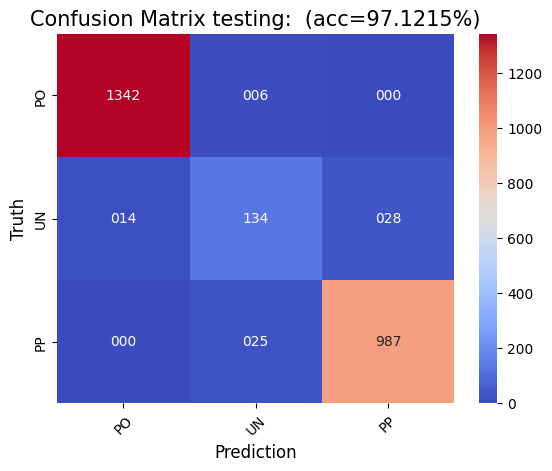

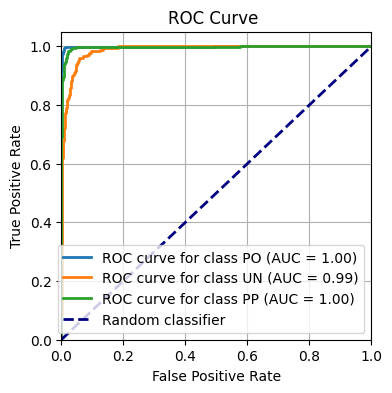

(array([[1342,    6,    0],
        [  14,  134,   28],
        [   0,   25,  987]], dtype=int64),
 {0: 0.9992275624694023, 1: 0.9872135015408319, 2: 0.9972119344765699})

In [216]:
print("evaluate on test set")
y_pred_test = model_full_tfid.predict(X_test_full)
y_pred_prob_test = model_full_tfid.predict_proba(X_test_full)
print(model_full_tfid.predict_proba(X_test_full))
evaluate(y_test, y_pred_test, y_pred_prob_test)

evaluate on benchmark tweet only
Classification Report:
               precision    recall  f1-score   support

          PO       0.69      0.91      0.79       160
          PP       0.85      0.23      0.36        95
          UN       0.81      0.97      0.88        98

    accuracy                           0.74       353
   macro avg       0.78      0.70      0.68       353
weighted avg       0.77      0.74      0.70       353



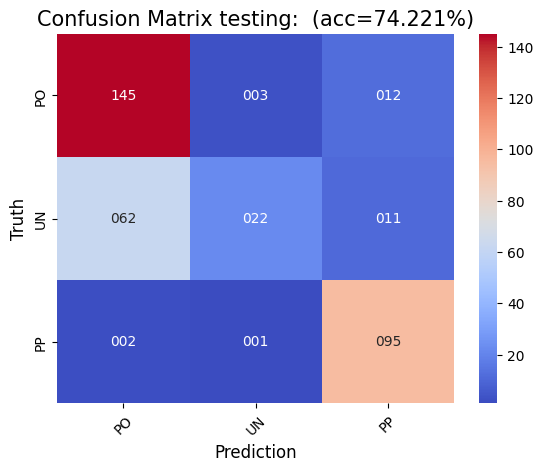

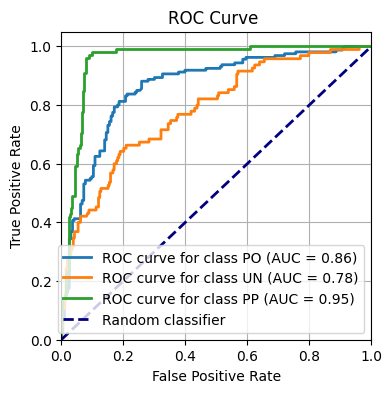

(array([[145,   3,  12],
        [ 62,  22,  11],
        [  2,   1,  95]], dtype=int64),
 {0: 0.8622895077720207, 1: 0.7823541411668706, 2: 0.9525010004001601})

In [217]:
print("evaluate on benchmark tweet only")
X_bench_tweet = tf_id_vectorizer.transform(benchmark_tweet)
y_pred_bench_tweet = model_tweet_tfid.predict(X_bench_tweet)
y_pred_prob_bench_tweet = model_tweet_tfid.predict_proba(X_bench_tweet)
evaluate(benchmark_target, y_pred_bench_tweet , y_pred_prob_bench_tweet)

evaluate on benchmark tweet + LWIC
Classification Report:
               precision    recall  f1-score   support

          PO       0.90      0.88      0.89       160
          PP       0.88      0.86      0.87        95
          UN       0.89      0.95      0.92        98

    accuracy                           0.89       353
   macro avg       0.89      0.90      0.89       353
weighted avg       0.89      0.89      0.89       353



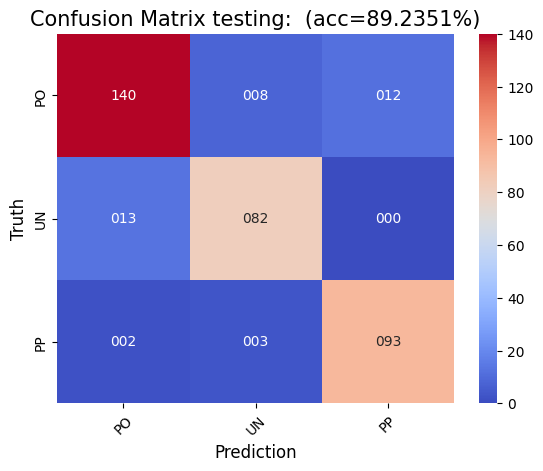

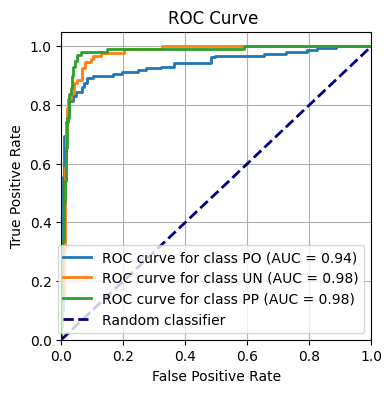

(array([[140,   8,  12],
        [ 13,  82,   0],
        [  2,   3,  93]], dtype=int64),
 {0: 0.9397020725388601, 1: 0.9751529987760098, 2: 0.9781912765106042})

In [218]:

print("evaluate on benchmark tweet + LWIC")
X_bench_full = np.concatenate(
    (benchmark_full, X_bench_tweet.toarray()), axis=1)
y_pred_bench_full = model_full_tfid.predict(X_bench_full)
y_pred_proba_bench_full = model_full_tfid.predict_proba(X_bench_full)
evaluate(benchmark_target, y_pred_bench_full, y_pred_proba_bench_full)

In [219]:
# bag of word
cnt_vectorizer = CountVectorizer(stop_words='english', min_df=0.01,)
X_train_bow = cnt_vectorizer.fit_transform(X_train_tweet)
X_test_bow = cnt_vectorizer.transform(X_test_tweet)


print("Using Bag of Words")

print("bow shape: ", X_train_bow.shape)
X_train_full = np.concatenate((X_train, X_train_bow.toarray()), axis=1)
X_test_full = np.concatenate((X_test, X_test_bow.toarray()), axis=1)

print("full shape: ", X_train_full.shape)

model_full_bow = do_logistic_regression(X_train_full, X_test_full)
model_tweet_bow = do_logistic_regression(X_train_bow, X_test_bow)

Using Bag of Words
bow shape:  (10142, 220)
full shape:  (10142, 338)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] END .............................................C=0.01; total time=   0.9s
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END ..............................................C=0.1; total time=   2.2s
[CV] END ..............................................C=0.1; total time=   3.9s
[CV] END ..............................................C=0.1; total time=   4.5s
[CV] END ..............................................C=0.1; total time=   1.9s
[CV] END ................................................C=1; total time=   4.7s
[CV] END ................................................C=1; total time=   5.4s
[CV] END ................................................C=1

evaluate on test set
Classification Report:
               precision    recall  f1-score   support

          PO       0.99      1.00      0.99      1348
          PP       0.82      0.76      0.78       176
          UN       0.97      0.98      0.97      1012

    accuracy                           0.97      2536
   macro avg       0.93      0.91      0.92      2536
weighted avg       0.97      0.97      0.97      2536



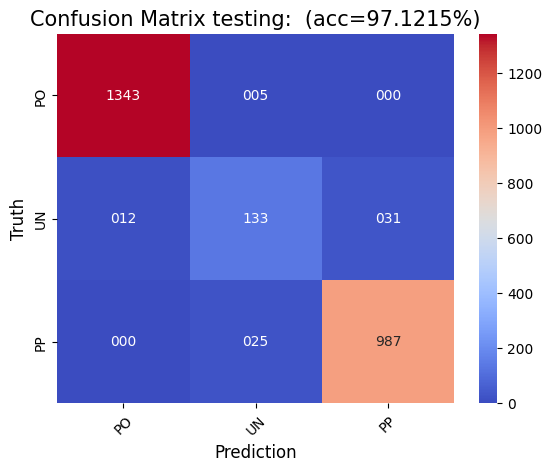

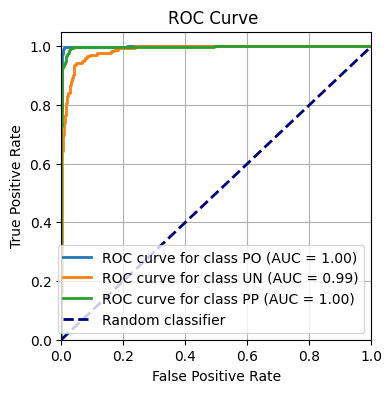

(array([[1343,    5,    0],
        [  12,  133,   31],
        [   0,   25,  987]], dtype=int64),
 {0: 0.9992918802265983, 1: 0.9859928736517719, 2: 0.9976839604535599})

In [220]:

print("evaluate on test set")
y_pred_test = model_full_bow.predict(X_test_full)
y_pred_prob_test = model_full_bow.predict_proba(X_test_full)
evaluate(y_test, y_pred_test, y_pred_prob_test)

evaluate on benchmark tweet only
Classification Report:
               precision    recall  f1-score   support

          PO       0.69      0.91      0.78       160
          PP       0.77      0.21      0.33        95
          UN       0.81      0.94      0.87        98

    accuracy                           0.73       353
   macro avg       0.75      0.69      0.66       353
weighted avg       0.74      0.73      0.68       353



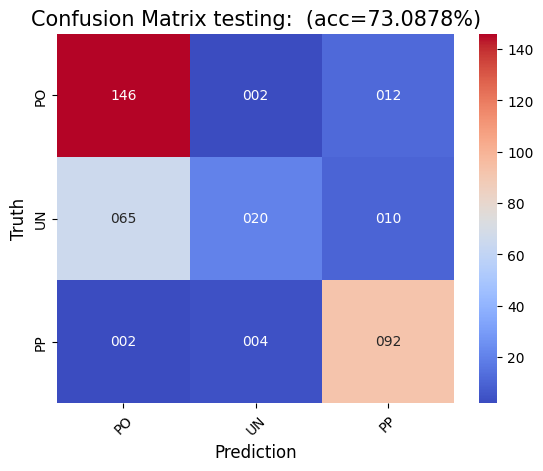

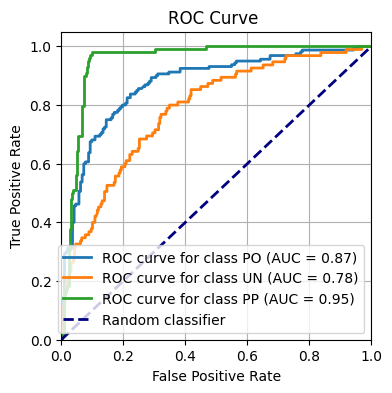

(array([[146,   2,  12],
        [ 65,  20,  10],
        [  2,   4,  92]], dtype=int64),
 {0: 0.8715187823834197, 1: 0.7837005303957569, 2: 0.950500200080032})

In [221]:

print("evaluate on benchmark tweet only")
X_bench_tweet = cnt_vectorizer.transform(benchmark_tweet)
y_pred_bench_tweet = model_tweet_bow.predict(X_bench_tweet)
y_pred_prob_bench_tweet = model_tweet_bow.predict_proba(X_bench_tweet)
evaluate(benchmark_target, y_pred_bench_tweet, y_pred_prob_bench_tweet)

evaluate on benchmark tweet + LWIC
Classification Report:
               precision    recall  f1-score   support

          PO       0.92      0.89      0.91       160
          PP       0.92      0.89      0.91        95
          UN       0.89      0.96      0.92        98

    accuracy                           0.91       353
   macro avg       0.91      0.92      0.91       353
weighted avg       0.91      0.91      0.91       353



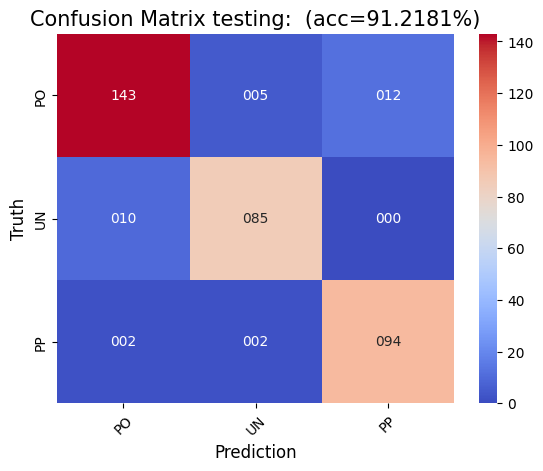

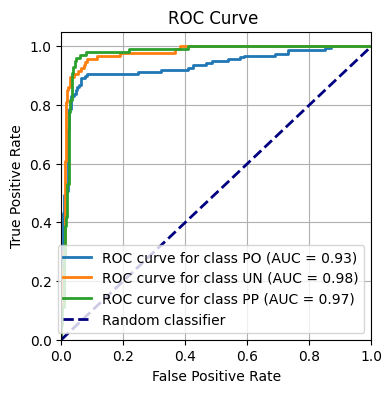

(array([[143,   5,  12],
        [ 10,  85,   0],
        [  2,   2,  94]], dtype=int64),
 {0: 0.9337435233160621, 1: 0.9754793961648307, 2: 0.9744297719087636})

In [222]:
print("evaluate on benchmark tweet + LWIC")
X_test_full = np.concatenate((benchmark_full, X_bench_tweet.toarray()), axis=1)
y_pred_bench_full= model_full_bow.predict(X_test_full)
y_pred_prob_bench_full = model_full_bow.predict_proba(X_test_full)
evaluate(benchmark_target, y_pred_bench_full, y_pred_prob_bench_full)

In [223]:
# word2vec
print("Using Word2Vec")
print("vec shape: ", X_train_vec.shape)
X_train_full = np.concatenate((X_train, X_train_vec), axis=1)
X_test_full = np.concatenate((X_test, X_test_vec), axis=1)
print("full shape: ", X_train_full.shape)

model_full_vec = do_logistic_regression(X_train_full, X_test_full)
model_tweet_vec = do_logistic_regression(X_train_vec, X_test_vec)

Using Word2Vec
vec shape:  (10142, 100)
full shape:  (10142, 218)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] END .............................................C=0.01; total time=   1.7s
[CV] END .............................................C=0.01; total time=   1.4s
[CV] END .............................................C=0.01; total time=   1.5s
[CV] END .............................................C=0.01; total time=   1.1s
[CV] END ..............................................C=0.1; total time=   5.4s
[CV] END ..............................................C=0.1; total time=   5.2s
[CV] END ..............................................C=0.1; total time=   4.6s
[CV] END ..............................................C=0.1; total time=   4.1s
[CV] END ................................................C=1; total time=  16.3s
[CV] END ................................................C=1; total time=  11.9s
[CV] END ................................................C=1; to

evaluate on test set
Classification Report:
               precision    recall  f1-score   support

          PO       0.97      0.97      0.97      1348
          PP       0.80      0.77      0.78       176
          UN       0.94      0.95      0.95      1012

    accuracy                           0.95      2536
   macro avg       0.90      0.90      0.90      2536
weighted avg       0.95      0.95      0.95      2536



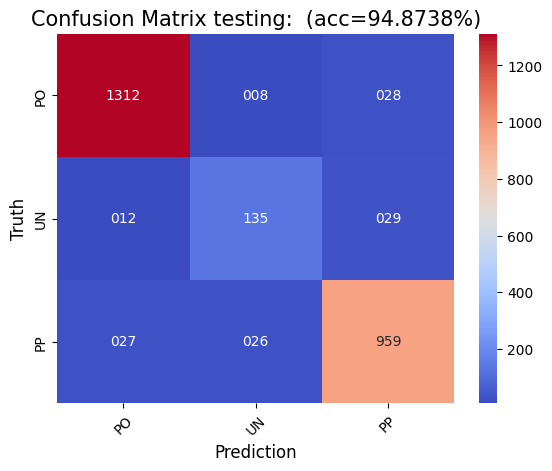

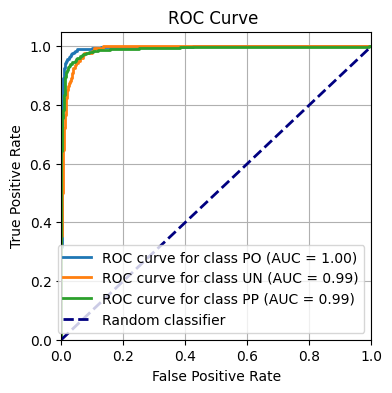

(array([[1312,    8,   28],
        [  12,  135,   29],
        [  27,   26,  959]], dtype=int64),
 {0: 0.995695081377574, 1: 0.988482280431433, 2: 0.9899227641011277})

In [224]:

print("evaluate on test set")
y_pred_test = model_full_vec.predict(X_test_full)
y_pred_proba_test = model_full_vec.predict_proba(X_test_full)
evaluate(y_test, y_pred_test, y_pred_proba_test)

In [225]:

print("evaluate on benchmark tweet only")
X_bench_tweet = np.array([text_to_mean_vector(
    text, word2vec_model) for text in benchmark_tweet])
y_pred_bench_tweet = model_tweet_vec.predict(X_bench_tweet)
y_pred_prob_bench_tweet = model_tweet_vec.predict_proba(X_bench_tweet)
evaluate(benchmark_target, y_pred_bench_tweet)

evaluate on benchmark tweet only


TypeError: evaluate() missing 1 required positional argument: 'y_pred_prob_test'

In [ ]:
print("evaluate on benchmark tweet + LWIC")
X_bench_full = np.concatenate((benchmark_full, X_bench_tweet), axis=1)
y_pred_bench_full = model_full_vec.predict(X_bench_full)
y_pred_prob_bench_full = model_full_vec.predict_proba(X_bench_full)
evaluate(benchmark_target, y_pred_bench_full, y_pred_prob_bench_full)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Function to perform grid search and model fitting using Random Forest


def do_randomforest(X_tr, X_te):
    # Setting up the Random Forest model
    rf = RandomForestClassifier()

    # Defining the parameter grid for grid search
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    # Performing grid search with 5-fold cross-validation
    grid_search = GridSearchCV(rf, param_grid, cv=4, scoring='accuracy')
    grid_search.fit(X_tr, y_train)

    # Best parameters found by grid search
    best_params = grid_search.best_params_
    print('Best parameters found by grid search:', best_params)

    # Training the model with the best parameters
    best_model = grid_search.best_estimator_

    return best_model

Using TF-IDF
tf-idf shape:  (10142, 220)
full shape:  (10142, 339)
Best parameters found by grid search: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

          PO       0.99      1.00      0.99      1348
          PP       0.88      0.64      0.74       176
          UN       0.95      0.99      0.97      1012

    accuracy                           0.97      2536
   macro avg       0.94      0.88      0.90      2536
weighted avg       0.97      0.97      0.97      2536



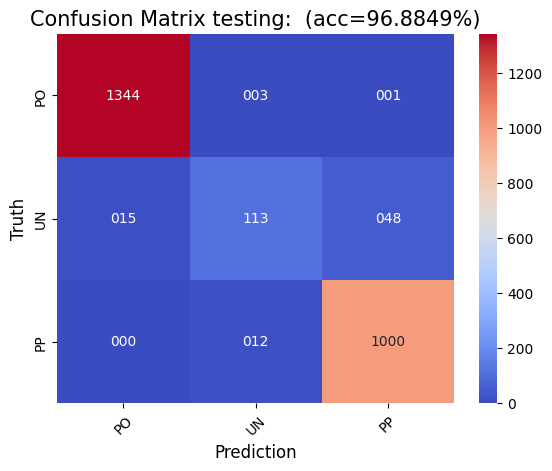

In [ ]:
print("Using TF-IDF")
print("tf-idf shape: ", X_train_tweet_tfid.shape)
X_train_full = np.concatenate((X_train, X_train_tweet_tfid.toarray()), axis=1)
X_test_full = np.concatenate((X_test, X_test_tweet_tfid.toarray()), axis=1)
print("full shape: ", X_train_full.shape)

model_full_tfid = do_randomforest(X_train_full, X_test_full)
model_tweet_tfid = do_randomforest(X_train_tweet_tfid, X_test_tweet_tfid)

In [ ]:
print("evaluate on test set")
y_pred_test = model_full_tfid.predict(X_test_full)
evaluate(y_test, y_pred_test)

In [ ]:

print("evaluate on benchmark tweet only")
X_bench_tweet = tf_id_vectorizer.transform(benchmark_tweet)
y_pred_bench_tweet = model_tweet_tfid.predict()
evaluate(benchmark_target, y_pred_bench_tweet)

In [ ]:
print("evaluate on benchmark tweet + LWIC")
X_bench_full = np.concatenate(
    (benchmark_full, X_bench_tweet.toarray()), axis=1)
y_pred_bench_full = model_full_tfid.predict(benchmark_full)
y_pred_prob_bench_full = model_full_tfid.predict_proba(X_bench_full)
evaluate(benchmark_target, y_pred_bench_full, y_pred_prob_bench_full)

Using Bag of Words
bow shape:  (10142, 220)
full shape:  (10142, 339)
Best parameters found by grid search: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

          PO       0.99      1.00      0.99      1348
          PP       0.87      0.64      0.74       176
          UN       0.95      0.99      0.97      1012

    accuracy                           0.97      2536
   macro avg       0.94      0.87      0.90      2536
weighted avg       0.97      0.97      0.97      2536



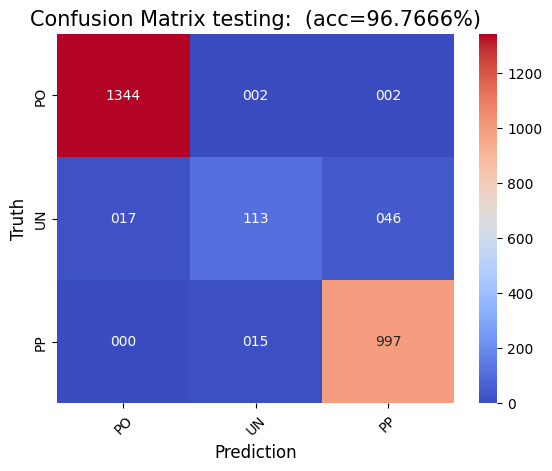

In [ ]:
# bag of word
print("Using Bag of Words")
print("bow shape: ", X_train_bow.shape)
X_train_full = np.concatenate((X_train, X_train_bow.toarray()), axis=1)
X_test_full = np.concatenate((X_test, X_test_bow.toarray()), axis=1)
print("full shape: ", X_train_full.shape)

model_full_bow = do_randomforest(X_train_full, X_test_full)
model_tweet_bow = do_randomforest(X_train_bow, X_test_bow)

In [ ]:
print("evaluate on test set")
y_pred_test = model_full_bow.predict(X_test_full)
evaluate(y_test, y_pred_test)

In [ ]:

print("evaluate on benchmark tweet only")
X_bench_tweet = cnt_vectorizer.transform(benchmark_tweet)
y_pred_bench_tweet = model_tweet_bow.predict()
y_pred_prob_bench_tweet = model_tweet_bow.predict_proba(X_bench_tweet)
evaluate(benchmark_target, y_pred_bench_tweet, y_pred_prob_bench_tweet)

In [ ]:

print("evaluate on benchmark tweet + LWIC")
X_bench_full = np.concatenate(
    (benchmark_full, X_bench_tweet.toarray()), axis=1)
y_pred_bench_full = model_full_bow.predict(benchmark_full)
y_pred_prob_bench_full = model_full_bow.predict_proba(X_bench_full)
evaluate(benchmark_target, y_pred_bench_full, y_pred_prob_bench_full)

Using Word2Vec
vec shape:  (10142, 100)
full shape:  (10142, 219)
Best parameters found by grid search: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

          PO       0.96      0.99      0.97      1348
          PP       0.86      0.68      0.76       176
          UN       0.95      0.94      0.94      1012

    accuracy                           0.95      2536
   macro avg       0.92      0.87      0.89      2536
weighted avg       0.95      0.95      0.95      2536



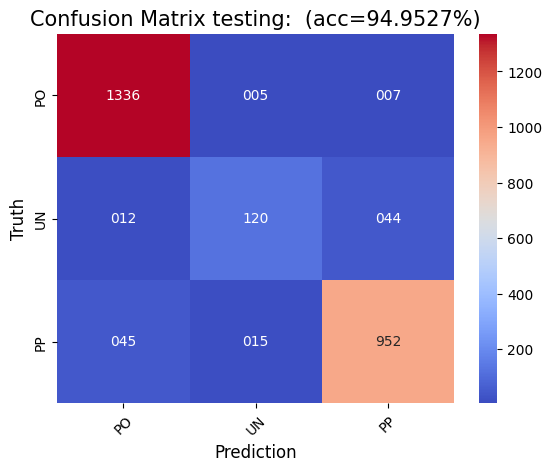

In [ ]:
# word2vec
print("Using Word2Vec")
print("vec shape: ", X_train_vec.shape)
X_train_full = np.concatenate((X_train, X_train_vec), axis=1)
X_test_full = np.concatenate((X_test, X_test_vec), axis=1)
print("full shape: ", X_train_full.shape)

model_full_vec = do_randomforest(X_train_full, X_test_full)
model_tweet_vec = do_randomforest(X_train_vec, X_test_vec)

In [ ]:
print("evaluate on test set")
y_pred_test = model_full_vec.predict(X_test_full)
y_pred_prob_test = model_full_vec.predict_proba(X_test_full)
evaluate(y_test, y_pred_test, y_pred_prob_test)

In [ ]:
print("evaluate on benchmark tweet only")
X_bench_tweet = np.array([text_to_mean_vector(
    text, word2vec_model) for text in benchmark_tweet])
y_pred_bench_tweet = model_tweet_vec.predict(X_bench_tweet)
y_pred_prob_bench_tweet = model_tweet_vec.predict_proba(X_bench_tweet)
evaluate(benchmark_target, y_pred_bench_tweet, y_pred_prob_bench_tweet)

In [ ]:
print("evaluate on benchmark tweet + LWIC")
X_bench_full = np.concatenate((benchmark_full, X_bench_tweet), axis=1)
y_pred_bench_full = model_full_vec.predict(X_bench_full)
y_pred_prob_bench_full = model_full_vec.predict_proba(X_bench_full)
evaluate(benchmark_target, y_pred_bench_full, y_pred_prob_bench_full)

# test tweet

In [ ]:
txt = "ATTENTION: Dear citizens, I appeal to all of you not to panic. Seal down orders are only in Ward 134 Bapuji Nagar &amp; Ward 135 Padarayanapura due to fresh cases &amp; to contain spread of #Covid19. Urge TV news channels to report facts &amp; not speculate @BBMPCOMM @BlrCityPolice"
txt_vec = count_vect.transform([txt])
feature_names_bow = count_vect.get_feature_names_out()
df_txt = pd.DataFrame(txt_vec.toarray(), columns=feature_names_bow)
display(df_txt.value_counts(sort=True))
model = do_logistic_regression(X_train_bow, X_test_bow)
pred = model.predict(txt_vec)
print(pred)

# print(df_txt.where(df_txt != 0))

000  10  19  2020  able  americans  amid  amp  anxiety  april  avoid  away  bad  believe  best  better  breath  breathing  buy  buying  calm  care  case  cases  cause  caused  causing  check  chest  chill  chills  china  come  common  community  control  corona  coronavirus  coronavirusoutbreak  coronaviruspandemic  cough  coughing  country  covid  covid19  covid19pandemic  covid2019  covid_19  covidー19  create  crisis  daily  data  day  days  death  deaths  depressed  depression  did  die  discomfort  disease  distancing  doctor  doctors  does  doesn  doing  don  dr  economy  end  experts  face  fake  family  fear  feel  feeling  fever  fight  flu  follow  food  free  friends  getting  global  god  going  good  got  government  great  hand  hands  having  head  health  healthy  heart  help  high  hold  home  hope  hospital  important  india  indiafightscorona  information  instead  isolation  just  know  learn  let  life  like  listen  live  lives  ll  lockdown  long  look  love  make

Best parameters found by grid search: {'C': 1, 'penalty': 'l1'}
['PO']
